In [40]:
import os
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [41]:
os.getcwd()

'/UbuntuHDD/Social-Rec-Sys/Transformer_modified'

In [42]:
os.listdir(os.getcwd() + '/dataset/')

['epinions', 'ciao', 'toy']

## Raw data (Ciao)

- `data_utils.py` 를 통해 생성된 (id-filtering 및 re-arranging을 거친) .csv 파일을 사용.

In [43]:
data_path = os.getcwd() + '/dataset/' + 'ciao'

rating_file = data_path + '/rating.csv'
trust_file = data_path + '/trustnetwork.csv'

rating_df = pd.read_csv(rating_file, index_col=[])
trust_df = pd.read_csv(trust_file, index_col=[])

In [44]:
rating_df

,user_id,product_id,rating
0,1,1,3
1,1,2,4
2,1,3,4
3,1,4,5
4,1,5,4
...,...,...,...
283315,7317,73109,1
283316,7317,25251,3
283317,7317,72478,4
283318,7317,74659,5


### rating 받은 수 분포

In [45]:
rating_df['rating'].value_counts()

rating
5    138514
4     88261
3     31210
2     14282
1     11019
0        34
Name: count, dtype: int64

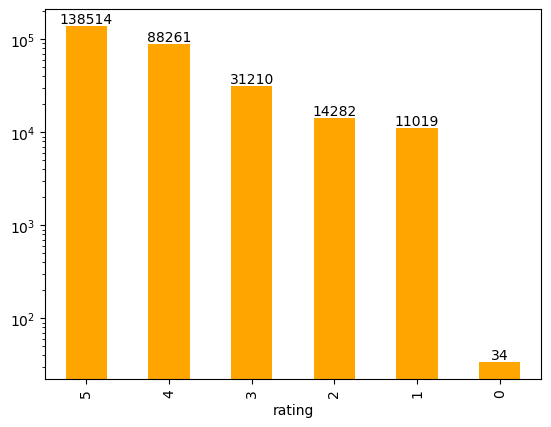

In [46]:
ax = rating_df['rating'].value_counts().plot(kind='bar', logy=True, color='orange')

for i, v in enumerate(rating_df['rating'].value_counts()):
    ax.text(i, v, str(v), ha='center', va='bottom')

In [47]:
trust_df

,user_id_1,user_id_2
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6
...,...,...
111776,7315,7316
111777,7315,7314
111778,7316,7315
111779,7316,7314


### rating matrix에서 사용자가 상호작용한 아이템 수 정보

In [48]:
user_item_dataframe = rating_df.groupby('user_id').agg({'product_id': list, 'rating': list}).reset_index()
user_item_dataframe['num_items'] = user_item_dataframe['product_id'].apply(lambda x: len(x))
user_item_dataframe['num_items'].describe()

count    7317.000000
mean       38.720787
std        73.220846
min         4.000000
25%        10.000000
50%        18.000000
75%        38.000000
max      1551.000000
Name: num_items, dtype: float64

- 사용자 마다 상호작용한 아이템의 수는 **평균 38개**, **최대 1551개**
  - 현재 Q75는 38. 이는 즉 **아이템과 상호작용을 극단적으로 많이 한 사용자가 존재**한다는 것.

<Axes: title={'center': "Number of user's interacted items"}, xlabel='user_id'>

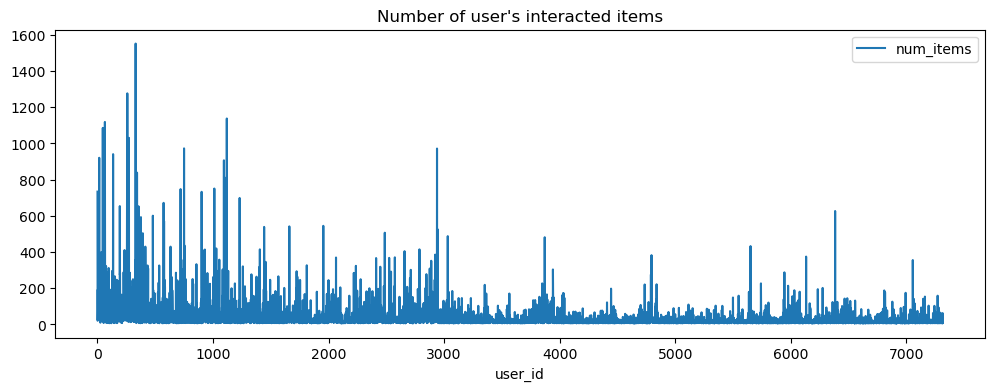

In [49]:
user_item_dataframe.plot(kind='line', x='user_id', y='num_items', figsize=(12, 4), title="Number of user's interacted items")

### rating matrix에서 아이템과 상호작용한 사용자 수 정보

In [50]:
item_user_dataframe = rating_df.groupby('product_id').agg({'user_id': list, 'rating': list}).reset_index()
item_user_dataframe['num_users'] = item_user_dataframe['user_id'].apply(lambda x: len(x))
item_user_dataframe['num_users'].describe(), item_user_dataframe

(count    104975.000000
 mean          2.698928
 std           9.023276
 min           1.000000
 25%           1.000000
 50%           1.000000
 75%           2.000000
 max         969.000000
 Name: num_users, dtype: float64,
         product_id       user_id     rating  num_users
 0                1           [1]        [3]          1
 1                2           [1]        [4]          1
 2                3           [1]        [4]          1
 3                4  [1, 83, 244]  [5, 3, 3]          3
 4                5           [1]        [4]          1
 ...            ...           ...        ...        ...
 104970      104971        [7314]        [5]          1
 104971      104972        [7312]        [5]          1
 104972      104973        [7312]        [5]          1
 104973      104974        [7316]        [5]          1
 104974      104975        [7317]        [1]          1
 
 [104975 rows x 4 columns])

In [51]:
df = rating_df.groupby('product_id')['user_id'].nunique().reset_index()
df.columns = ['product_id', 'degree']
df['degree'].describe()

count    104975.000000
mean          2.685382
std           8.900015
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         912.000000
Name: degree, dtype: float64

- *왜 차이가 발생하는가?*
    - `rating_df.groupby('product_id').agg({'user_id': list, 'rating': list}).reset_index()`*는 한 사용자가 한 아이템에 여러번 평점 매겼다면 여러번을 모두 셈.*
    - `rating_df.groupby('product_id')['user_id'].nunique().reset_index()`*는 한 사용자가 한 아이템에 여러번 평점 매겼다면 한번만을 셈.*
- 후자의 방법이 현재 degree를 세고 있음.

- 아이템마다 상호작용한 사용자 수는 평균 2.6명, 최대 969명
  - 현재 Q75는 2. 마찬가지로 **사용자에게 상호작용을 극단적으로 많이 받은 아이템**이 존재한다는 것.

<Axes: title={'center': "Number of user's interacted items"}, xlabel='product_id'>

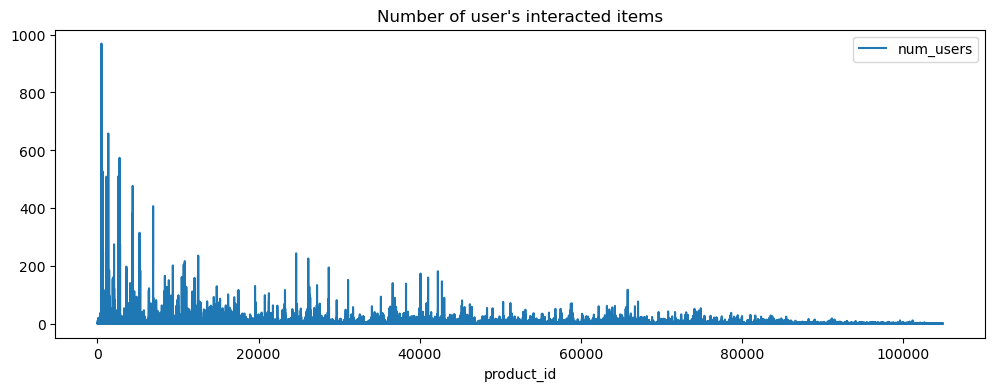

In [52]:
item_user_dataframe.plot(kind='line', x='product_id', y='num_users', figsize=(12, 4), title="Number of user's interacted items")

### rating matrix sparsity check

In [54]:
user_item_matrix = rating_df.pivot_table(
    values='rating',
    index='user_id',
    columns='product_id'
).fillna(0).to_numpy()
user_item_matrix

array([[3., 4., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 5., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [55]:
user_item_matrix.shape

(7317, 104975)

In [56]:
sparsity = 1.0 - (np.count_nonzero(user_item_matrix) / float(user_item_matrix.size))
print(f"Sparsity of rating matrix: {sparsity * 100:.4f}%")

Sparsity of rating matrix: 99.9633%


### social graph 사용자 정보 및 sparsity check

In [26]:
max(trust_df['user_id_1']), max(trust_df['user_id_2'])

(7317, 7317)

In [71]:
len(trust_df)

111781

In [60]:
social_deg = pd.read_csv(data_path + '/degree_table_social.csv', index_col=[])
social_deg['degree'].describe()

count    7317.000000
mean       23.289600
std        44.644794
min         1.000000
25%         3.000000
50%         8.000000
75%        24.000000
max       804.000000
Name: degree, dtype: float64

In [67]:
user_user_matrix = nx.from_pandas_edgelist(trust_df, source='user_id_1', target='user_id_2').to_undirected()
user_user_matrix = nx.to_numpy_array(user_user_matrix)
user_user_matrix, user_user_matrix.shape

(array([[0., 1., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (7317, 7317))

In [68]:
sparsity = 1.0 - (np.count_nonzero(user_user_matrix) / float(user_user_matrix.size))
print(f"Sparsity of social graph: {sparsity * 100:.4f}%")

Sparsity of social graph: 99.6817%


In [70]:
np.count_nonzero(user_user_matrix) / float(user_user_matrix.size)

0.00318294376966821

### social graph에서의 SPD table 정보

- 이 과정은 `_test16_spd_statistics.py` 에서 진행된 내역임.

In [73]:
# (num_user, num_user) 크기의 SPD table. 모든 user 쌍 간의 최단거리를 계산한 테이블임.
spd_table = np.load(data_path + '/shortest_path_result.npy')
spd_table

array([[0, 1, 1, ..., 6, 6, 4],
       [1, 0, 1, ..., 6, 6, 4],
       [1, 1, 0, ..., 6, 6, 5],
       ...,
       [6, 6, 6, ..., 0, 1, 2],
       [6, 6, 6, ..., 1, 0, 2],
       [4, 4, 5, ..., 2, 2, 0]])

In [74]:
# count를 위해 대각성분을 특정 값으로 대체하고, 상삼각행렬만을 사용.
upper_triangle_table = np.triu(spd_table)
np.fill_diagonal(upper_triangle_table, 20000)
upper_triangle_table

array([[20000,     1,     1, ...,     6,     6,     4],
       [    0, 20000,     1, ...,     6,     6,     4],
       [    0,     0, 20000, ...,     6,     6,     5],
       ...,
       [    0,     0,     0, ..., 20000,     1,     2],
       [    0,     0,     0, ...,     0, 20000,     2],
       [    0,     0,     0, ...,     0,     0, 20000]])

In [76]:
# 각 수치마다 count 진행, 마지막에 20000에 대한 카운트(대각성분 카운트)는 제외
unique, counts = np.unique(upper_triangle_table[np.where(upper_triangle_table != 0)], return_counts=True)

# 편리한 look을 위한 dataframe
spd_info_df = pd.DataFrame(columns=['SPD', 'count'])
spd_info_df['SPD'] = unique
spd_info_df['count'] = counts

# 마지막 20000에 대한 카운트는 제외
spd_info_df = spd_info_df[:-1]
spd_info_df

,SPD,count
0,1,85205
1,2,3426321
2,3,13218976
3,4,8207453
4,5,1553433
5,6,167307
6,7,16883
7,8,2179
8,9,105
9,10,4


- 7318은 현재 unreachable distance로, 임의로 `max(num_nodes) + 1` 로 설정한 값임.
- 위 값은 diagonal ~ lower triangle 부분을 count안한 것이므로 전부 더해도 기존의 `(num_user, num_user)` 크기가 나오지 않음.

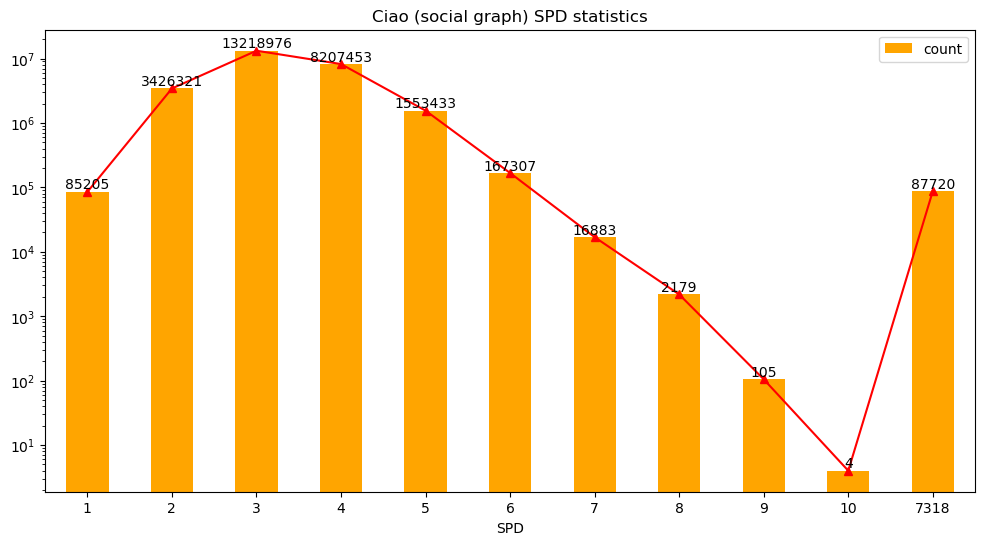

In [87]:
# plt.ticklabel_format(style='plain') # axis 값 범위가 1e7과 같이 표기되는 것을 방지하기 위함. -> log scale을 적용해서 문제 X

fig, ax = plt.subplots(figsize=(12, 6))
spd_info_df.plot(kind='bar', x='SPD', y='count' ,figsize=(12, 6), logy=True, color='orange', ax=ax)

for i, v in enumerate(spd_info_df['count']):
    ax.text(i, v, str(v), ha='center', va='bottom')

spd_info_df['count'].plot(kind='line', color='red', style='^-', ax=ax)
plt.title('Ciao (social graph) SPD statistics')
plt.show()

- 모든 쌍 간의 SPD 값을 count한 것으로, **노드-노드 pair 간 최단 거리가 2,3,4,5 가 많음**
  - 즉 **대부분의 사용자는 2~5 hop 이내로 서로 연결되어 있음**을 짐작할 수 있다.
- unreachable distance를 15정도로 설정하고, `shortest_path_result.npy` 를 다시 생성한다면 $\rightarrow$ SPD Embedding table의 size를 15로 두고 할 수 있을 것.
  - `max(num_user) + 1` 로 두는 것 보단 아무래도 embedding table size가 작아지니 공간을 쓸데 없이 많이 차지하진 않을 것.

## Raw Data (Epinions)

- 마찬가지로 `data_utils.py`를 통해 생성된 (id-filtering 및 re-arranging을 거친) .csv 파일을 사용.

In [88]:
data_path = os.getcwd() + '/dataset/' + 'epinions'

rating_file = data_path + '/rating.csv'
trust_file = data_path + '/trustnetwork.csv'

rating_df = pd.read_csv(rating_file, index_col=[])
trust_df = pd.read_csv(trust_file, index_col=[])

In [89]:
rating_df

,user_id,product_id,rating
0,17924,1,2
1,17924,2,2
2,17924,3,2
3,17924,4,5
4,17924,5,3
...,...,...,...
764688,15229,120816,4
764689,15229,21758,4
764690,15229,50121,5
764691,15229,35617,4


In [92]:
trust_df

,user_id_1,user_id_2
0,1,2
1,3,2
2,4,2
3,5,2
4,6,2
...,...,...
355749,16901,18013
355750,17382,18017
355751,18095,18096
355752,18097,18098


### rating 받은 수 분포

In [90]:
rating_df['rating'].value_counts()

rating
5    321832
4    241179
3    100153
2     57689
1     43840
Name: count, dtype: int64

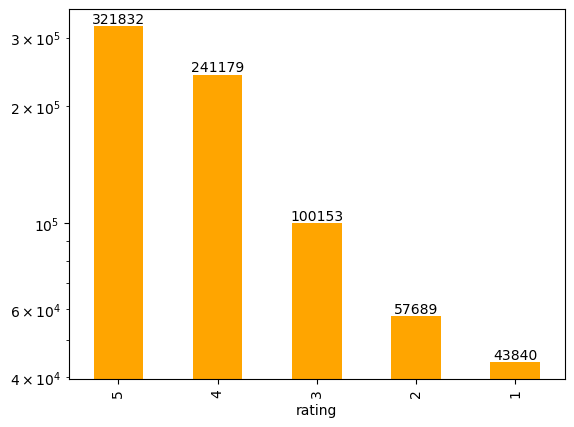

In [91]:
ax = rating_df['rating'].value_counts().plot(kind='bar', logy=True, color='orange')

for i, v in enumerate(rating_df['rating'].value_counts()):
    ax.text(i, v, str(v), ha='center', va='bottom')

### rating matrix에서 사용자가 상호작용한 아이템 수 정보

In [93]:
user_item_dataframe = rating_df.groupby('user_id').agg({'product_id': list, 'rating': list}).reset_index()
user_item_dataframe['num_items'] = user_item_dataframe['product_id'].apply(lambda x: len(x))
user_item_dataframe['num_items'].describe()

count    18097.000000
mean        42.255236
std        114.187036
min          1.000000
25%         13.000000
50%         19.000000
75%         34.000000
max       5357.000000
Name: num_items, dtype: float64

- 사용자마다 상호작용한 아이템 수는 **평균 42개, 최대 5357개**
  - 현재 Q75는 34. 이는 즉 **아이템과 상호작용을 극단적으로 많이 한 사용자가 존재**한다는 것.

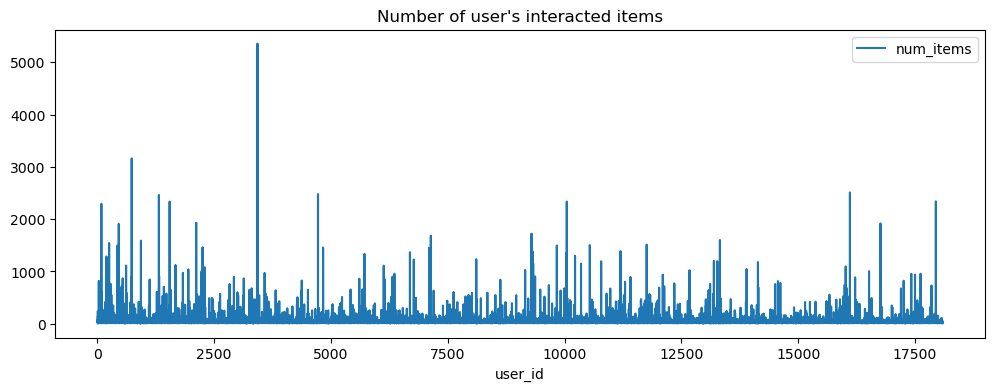

In [94]:
user_item_dataframe.plot(kind='line', x='user_id', y='num_items', figsize=(12, 4), title="Number of user's interacted items")
plt.show()

### rating matrix에서 아이템과 상호작용한 사용자 수 정보

In [97]:
item_user_dataframe = rating_df.groupby('product_id').agg({'user_id': list, 'rating': list}).reset_index()
item_user_dataframe['num_users'] = item_user_dataframe['user_id'].apply(lambda x: len(x))
print(item_user_dataframe['num_users'].describe())
item_user_dataframe

count    261679.000000
mean          2.922256
std          10.971157
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1510.000000
Name: num_users, dtype: float64


,product_id,user_id,rating,num_users
0,1,"[17924, 9652, 16054, 443, 5542, 10726, 4726, 1...","[2, 4, 5, 2, 4, 4, 4, 1, 4, 2, 3, 1, 3, 3, 3, ...",238
1,2,"[17924, 4549, 98, 14656, 5720, 5221, 10635, 12...","[2, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 4, 5, 3, ...",138
2,3,"[17924, 3010, 5418, 7361, 5781, 7765, 3370, 14...","[2, 3, 3, 2, 2, 5, 1, 5, 1, 4, 2, 1, 5, 2, 2, ...",34
3,4,"[17924, 2764, 2186, 4465, 17362, 3370, 456, 17...","[5, 4, 1, 5, 4, 5, 4, 4, 5, 3, 4, 2, 2, 4, 2, ...",47
4,5,"[17924, 5418, 6546, 5781, 7985, 777, 10784, 17...","[3, 2, 4, 2, 3, 3, 2, 4, 3, 5, 4, 3, 1, 4, 3, ...",63
...,...,...,...,...
261674,261675,[12463],[5],1
261675,261676,[9860],[4],1
261676,261677,[9860],[3],1
261677,261678,[15083],[3],1


In [98]:
df = rating_df.groupby('product_id')['user_id'].nunique().reset_index()
df.columns = ['product_id', 'degree']
df['degree'].describe()

count    261679.000000
mean          2.891627
std          10.726228
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1440.000000
Name: degree, dtype: float64

- Ciao와 마찬가지로 한 사용자가 여러번 매긴 평점을 모두 세는 1510으로 설정.

<br>

- 아이템마다 상호작용한 사용자 수는 평균 2.9며으 최대 1510명.
  - 현재 Q75는 2. 마찬가지로 **대부분의 사용자가 많은 상호작용을 하지 않고, 극단적으로 많은 상호작용을 받은 아이템**이 존재한다는 것.

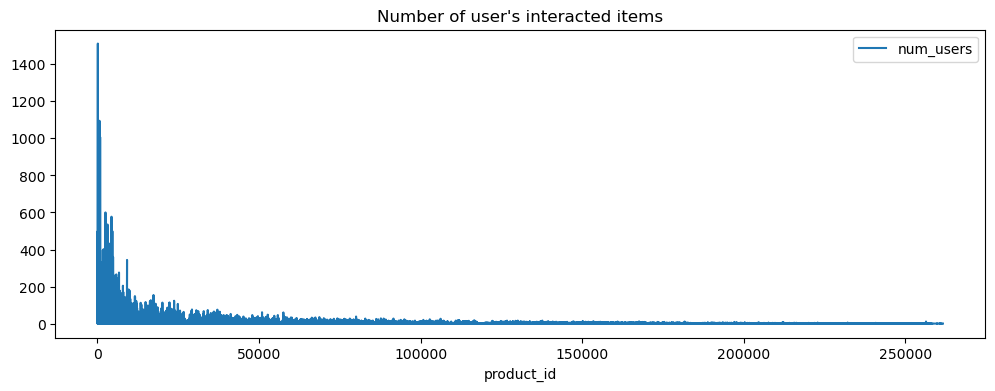

In [99]:
item_user_dataframe.plot(kind='line', x='product_id', y='num_users', figsize=(12, 4), title="Number of user's interacted items")
plt.show()

### rating matrix sparsity check

<br>

- (18097, 261679)을 dense matrix로 저장하기엔 무리가 있으므로, 단순히 shape를 통해서 계산.

In [101]:
sparsity = 1.0 - (rating_df.shape[0] / (user_item_dataframe.shape[0] * item_user_dataframe.shape[0]))
print(f"Sparsity of rating matrix: {sparsity * 100:.4f}%")

Sparsity of rating matrix: 99.9839%


### social graph 사용자 정보 및 sparsity check

In [106]:
max(trust_df['user_id_1']), max(trust_df['user_id_2'])

(18098, 18098)

In [108]:
len(trust_df)

355754

In [110]:
social_deg = pd.read_csv(data_path + '/degree_table_social.csv', index_col=[])
social_deg['degree'].describe()

count    18098.000000
mean        31.744502
std         75.193188
min          1.000000
25%          2.000000
50%          7.000000
75%         27.000000
max       2026.000000
Name: degree, dtype: float64

In [111]:
user_user_matrix = nx.from_pandas_edgelist(trust_df, source='user_id_1', target='user_id_2').to_undirected()
user_user_matrix = nx.to_numpy_array(user_user_matrix)
user_user_matrix, user_user_matrix.shape

(array([[0., 1., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]]),
 (18098, 18098))

In [112]:
sparsity = 1.0 - (np.count_nonzero(user_user_matrix) / float(user_user_matrix.size))
print(f"Sparsity of social graph: {sparsity * 100:.4f}%")

Sparsity of social graph: 99.8247%


In [113]:
np.count_nonzero(user_user_matrix) / float(user_user_matrix.size)

0.0017533498230023078

### social graph에서의 SPD table 정보

In [114]:
spd_table = np.load(data_path + '/shortest_path_result.npy')
spd_table

array([[    0,     1,     1, ..., 18099, 18099, 18099],
       [    1,     0,     1, ..., 18099, 18099, 18099],
       [    1,     1,     0, ..., 18099, 18099, 18099],
       ...,
       [18099, 18099, 18099, ...,     0, 18099, 18099],
       [18099, 18099, 18099, ..., 18099,     0,     1],
       [18099, 18099, 18099, ..., 18099,     1,     0]])

In [115]:
# count를 위해 대각성분을 특정 값으로 대체하고, 상삼각행렬만을 사용.
upper_triangle_table = np.triu(spd_table)
np.fill_diagonal(upper_triangle_table, 20000)
upper_triangle_table

array([[20000,     1,     1, ..., 18099, 18099, 18099],
       [    0, 20000,     1, ..., 18099, 18099, 18099],
       [    0,     0, 20000, ..., 18099, 18099, 18099],
       ...,
       [    0,     0,     0, ..., 20000, 18099, 18099],
       [    0,     0,     0, ...,     0, 20000,     1],
       [    0,     0,     0, ...,     0,     0, 20000]])

In [116]:
# 각 수치마다 count 진행, 마지막에 20000에 대한 카운트(대각성분 카운트)는 제외
unique, counts = np.unique(upper_triangle_table[np.where(upper_triangle_table != 0)], return_counts=True)

# 편리한 look을 위한 dataframe
spd_info_df = pd.DataFrame(columns=['SPD', 'count'])
spd_info_df['SPD'] = unique
spd_info_df['count'] = counts

# 마지막 20000에 대한 카운트는 제외
spd_info_df = spd_info_df[:-1]
spd_info_df

,SPD,count
0,1,287032
1,2,18854453
2,3,88435896
3,4,47781761
4,5,5969038
5,6,454172
6,7,27835
7,8,894
8,9,15
9,18099,1948657


- 18099는 현재 unreachable distance로, 임의로 `max(num_nodes) + 1`로 설정한 값임.
- 위 값은 diagonal ~ lower triangle 부분을 count 안한 것이므로 전부 더해도 기존의 `(num_user, num_user)` 크기가 나오지 않음.

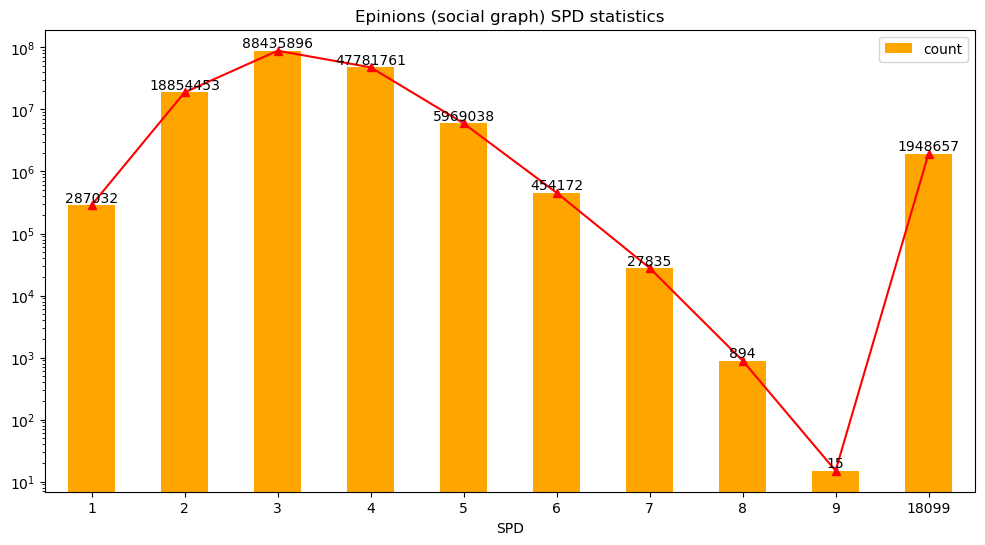

In [118]:
fig, ax = plt.subplots(figsize=(12, 6))
spd_info_df.plot(kind='bar', x='SPD', y='count' ,figsize=(12, 6), logy=True, color='orange', ax=ax)

for i, v in enumerate(spd_info_df['count']):
    ax.text(i, v, str(v), ha='center', va='bottom')

spd_info_df['count'].plot(kind='line', color='red', style='^-', ax=ax)
plt.title('Epinions (social graph) SPD statistics')
plt.show()

- Ciao와 마찬가지로 SPD 값을 count한 것으로, **노드-노드 pair 간 최단 거리가 2,3,4,5가 많음**
  - 또한 Ciao와는 다르게 서로 연결되지 않은 사용자 pair가 상당 수 존재함을 알 수 있음.
  - 이를 제외하면, **대부분의 사용자는 2~5hop 내외로 서로 연결되어 있음**을 짐작할 수 있다.
- unreachable distance를 마찬가지로 15 정도로 설정하고, `shortest_path_result.npy`를 다시 생성한다면 $\rightarrow$ SPD Embedding table의 size를 15로 두고 할 수 있을 것.
  - `max(num_user) + 1`로 두는 것 보단 아무래도 embedding table size가 작아지니 공간을 쓸데 없이 많이 차지하지 않을 것.